Jelle, July 2016

This notebooks is a WIMP analysis example using only one WIMP mass and an easy-to-compute rate uncertainty.

In [4]:
from copy import deepcopy

import numpy as np
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

from scipy import stats

from wimpy.likelihood import LogLikelihood
from wimpy.xenon.base_model import config
from wimpy.inference import bestfit_scipy, plot_likelihood_ratio, one_parameter_interval

# Create likelihoods

This creates two likelihood functions: a basic one, and one with a rather ridiculous 300% rate uncertainty on the neutron background. At least you'll see some effect of the profiling!

In [5]:
lf = LogLikelihood(config)
lf.add_rate_parameter('wimp_50gev')
lf.prepare()

plf = LogLikelihood(config)
plf.add_rate_parameter('wimp_50gev')
plf.add_rate_uncertainty('radiogenics', 3)   
plf.prepare()

# Example datasets

The code below creates four example datasets with increasing amounts of wimps. We plot the events in (cS1, cS2) space and the (profile) likelihood ratio of different WIMP rate hypotheses (with the best fit in the denominator). 

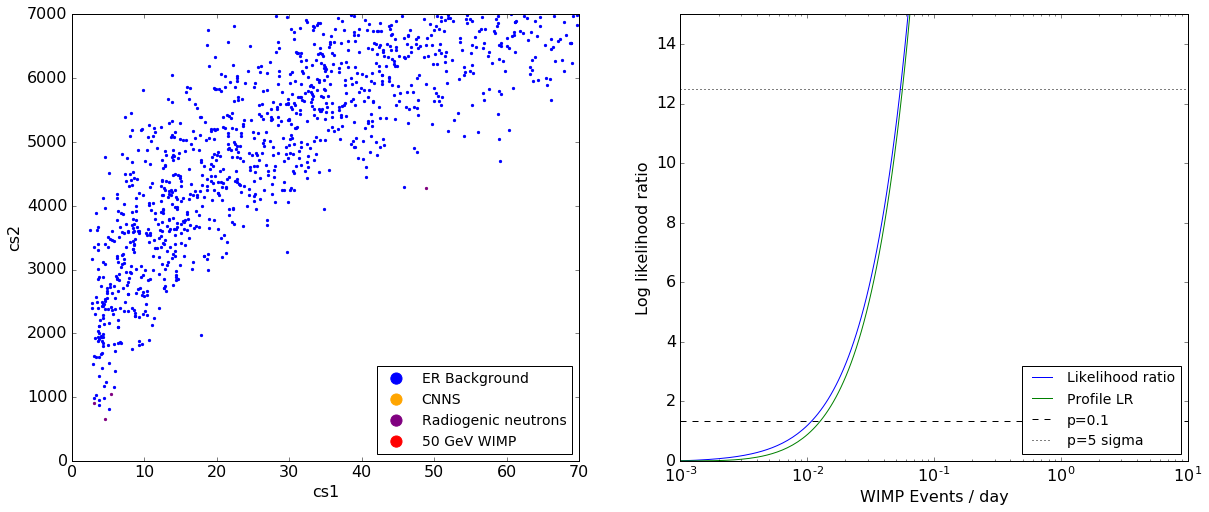

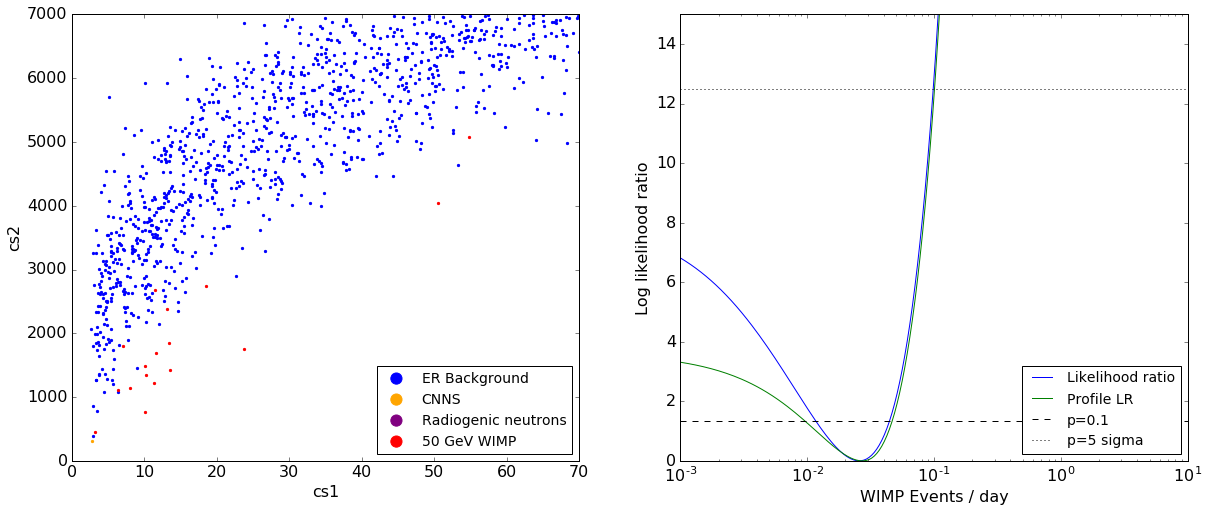

C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


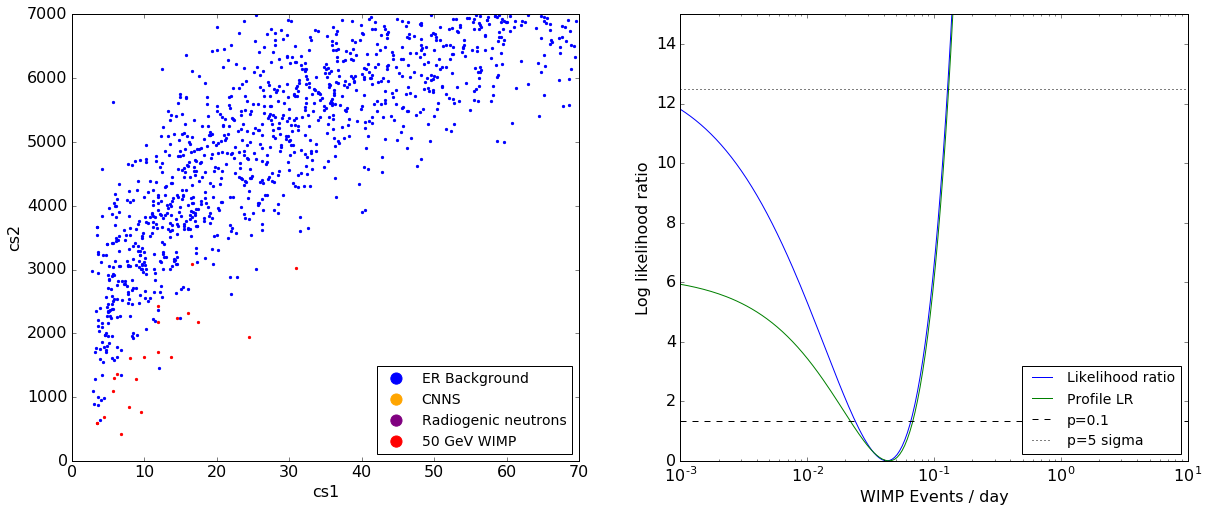

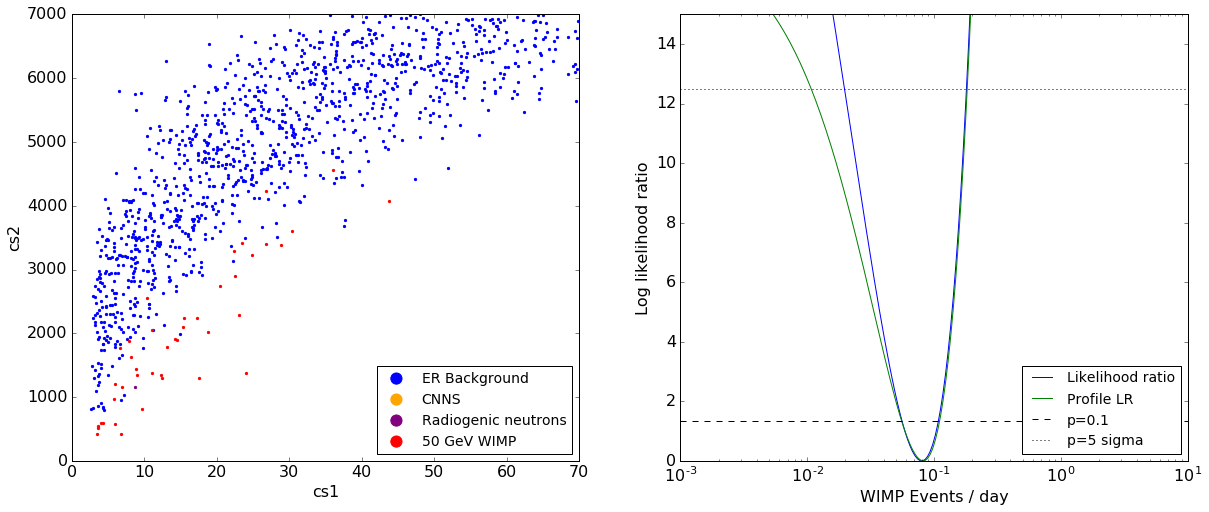

In [6]:
rate_multipliers = (0, 2e-2, 5e-2, 1e-1)
for i, mult in enumerate(rate_multipliers):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    plt.sca(ax1)
    
    d = lf.base_model.simulate(rate_multipliers=dict(wimp_50gev=mult))
    
    lf.base_model.show(d)
    plt.legend(loc='lower right', scatterpoints=1, markerscale=5, fontsize=14)
    
    plt.sca(ax2)
    lf.set_data(d)
    plf.set_data(d)
    space = ('wimp_50gev_rate', np.logspace(-3, 1, 200))
    plot_likelihood_ratio(lf, space,plot_kwargs=dict(label='Likelihood ratio'))
    plot_likelihood_ratio(plf, space, plot_kwargs=dict(label='Profile LR'))
    
    # p=0.1 line from Wilks' theorem
    plt.axhline(stats.chi2(1).ppf(0.9)/2,
                label='p=0.1', color='k', linestyle='--')
    plt.axhline(stats.chi2(1).ppf(stats.norm.cdf(5) - stats.norm.cdf(-5))/2,
                label='p=5 sigma', color='k', linestyle=':')
    plt.legend(frameon=True, loc='lower right', fontsize=14)
    plt.xlabel("WIMP Events / day")
    plt.xscale('log')
    plt.show()

The rates are in events/day, where events is the *total* number of WIMP events that happen in the fiducial volume (whether they produce detectable signals or not). 

# Sensitivity check

The sentivity of the experiment is the median limit on background-only data. Let's compute it for both the likelihood and profile likelihood:

In [8]:
n_trials = 1000

limits_lf = np.zeros(n_trials)
limits_plf = np.zeros(n_trials)

for i in tqdm(range(n_trials)):
    d = lf.base_model.simulate(rate_multipliers=dict(wimp_50gev=0))
    lf.set_data(d)
    plf.set_data(d)
    limits_lf[i] = one_parameter_interval(lf, 'wimp_50gev_rate', bound=1, kind='upper')
    limits_plf[i] = one_parameter_interval(plf, 'wimp_50gev_rate', bound=1, kind='upper')

  4%|██                                                | 42/1000 [00:07<03:05,  5.17it/s]C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


These limits are all set on the total rate of WIMP events (not just the rate producing detectable events), so to convert to limits on the cross section, we can just divide by the rate at the reference cross section (1e-45 cm2) for which the WIMP spectrum was generated.

In [10]:
reference_rate = lf.base_model.get_source('wimp_50gev').events_per_day
np.median(limits_lf / reference_rate) * 1e-45

8.2742953621299356e-48

The Bologna model (without CLS) [gave](https://xecluster.lngs.infn.it/dokuwiki/doku.php?id=xenon:xenon1t:sim:notes:digangi:sensitivity-profile-likelihood-ratio#with_or_without_cls) 8.6e-48... a nice agreement, considering they are completely different codes using different data dimensions for analysis.

# Coverage check

The limit setting code (`one_param_interval`) in wimpy.inference assumes Wilk's theorem holds, i.e. that the critical value for the loglikelihood ratio is as shown in the figures above. We can check this is indeed approximately true, by simulating many datasets at different WIMP masses, then computing the test statistic used in upper limit setting (twice the loglikelihood ratio, or 0 if the best fit is more signal-like than the hypothesis) at the true value.

The code will take some time, even though it only tests the ordinary likelihood ratio limit. If you have patience you can try the profile likelihood too: it will give similar results.

In [14]:
n_trials = int(1e4)
ts = {}

for rate in np.logspace(-3, 1, 7):
    ts[rate] = np.zeros(n_trials)
    for i in tqdm(range(n_trials), desc='Simulating likelihood ratios for %s events/day' % rate):
        d = lf.base_model.simulate(rate_multipliers=dict(wimp_50gev=rate/reference_rate))

        lf.set_data(d)
        bf = bestfit_scipy(lf)
        if bf[0]['wimp_50gev_rate'] > rate:
            ts[rate][i] = 0
        else:
            ts[rate][i] = 2 * (bf[1] - bestfit_scipy(lf, wimp_50gev_rate=rate)[1])

Simulating likelihood ratios for 0.001 events/day:   6%| | 576/10000 [00:06<01:47, 87.69it/s]C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


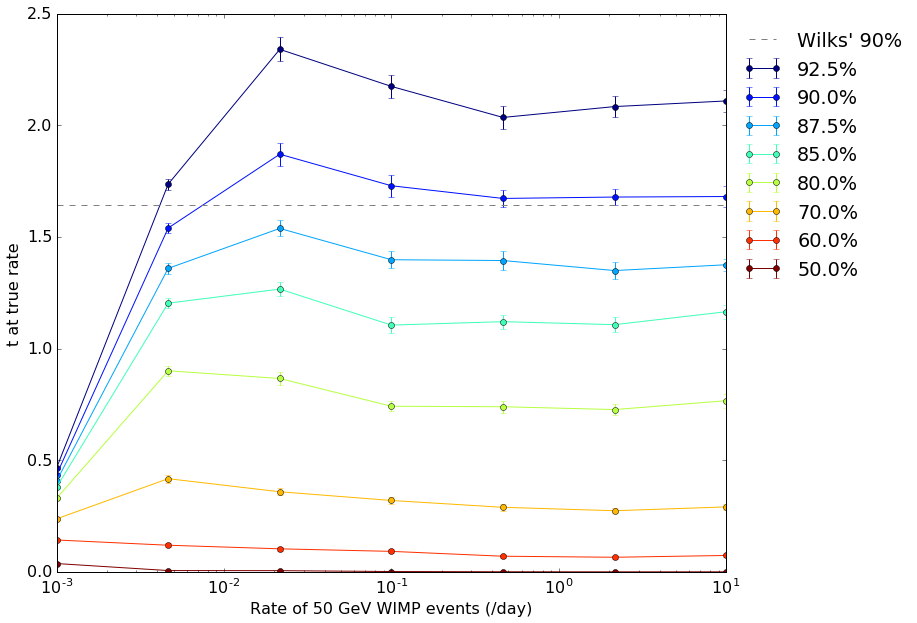

In [37]:
def bootstrap_percentile_error(q, pct, bootstrap_trials=200):
    return np.std([np.percentile(np.random.choice(q, len(q)), pct) for _ in range(bootstrap_trials)])

percentiles = [50, 60, 70, 80, 85, 87.5, 90, 92.5]
for i, pct in enumerate(tqdm(reversed(percentiles))):
    plt.errorbar(sorted(ts.keys()), 
                 [np.percentile(q, pct) for _, q in sorted(ts.items())],
                 yerr=[bootstrap_percentile_error(q, pct) for _, q in sorted(ts.items())],
                 color=plt.cm.jet(i/(len(percentiles)-1)),
                 label='%0.1f%%' % pct,
                 marker='o', linestyle='-')
plt.xscale('log')
plt.axhline(stats.norm.ppf(0.9)**2, linestyle='--', color='gray', label="Wilks' 90%")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, frameon=False)
plt.xlabel("Rate of 50 GeV WIMP events (/day)")
plt.ylabel("t at true rate")
plt.ylim(0, 2.5)
plt.show()

As you can see, for high rates Wilks' theorem holds rather well. Notice the points still fluctuate a bit (especially for high percentiles) due to MC statistical errors shown in the error bars (estimated by bootstrapping).

At lower rates some deviations start to show -- if you almost never see WIMPs you're not exactly in the asymptotic regime. First some mild undercoverage is observed, and at very low rates we overcover greatly . I think this is what we should expect, looking at https://www.pp.rhul.ac.uk/~cowan/stat/weizmann15/cowan_weizmann15_3.pdf, slide 26.

The reason that almost all likelihood ratios tend to zero at low rates is that these rates are essentially indistinguishable from having no WIMPs at all, which is also usually the best fit. Overcoverage below the sensitivity is good: you wouldn't want to exclude 1e-59 cm2 90% of the time!